# Budapest road network centrality analysis

In [1]:
import osmnx as ox
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import folium

Getting primary and secondary road segments from OpenStreetMap!

In [2]:
custom_filter = '["highway"~"primary|secondary"]'
G = ox.graph_from_place('Budapest, Hungary', network_type=None, infrastructure='way["highway"]', custom_filter=custom_filter)
Gu = ox.get_undirected(G)

/home/bokanyie/.anaconda3/lib/python3.7/site-packages/osmnx/projection.py:60: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs


The query results.

<Figure size 1080x1080 with 0 Axes>

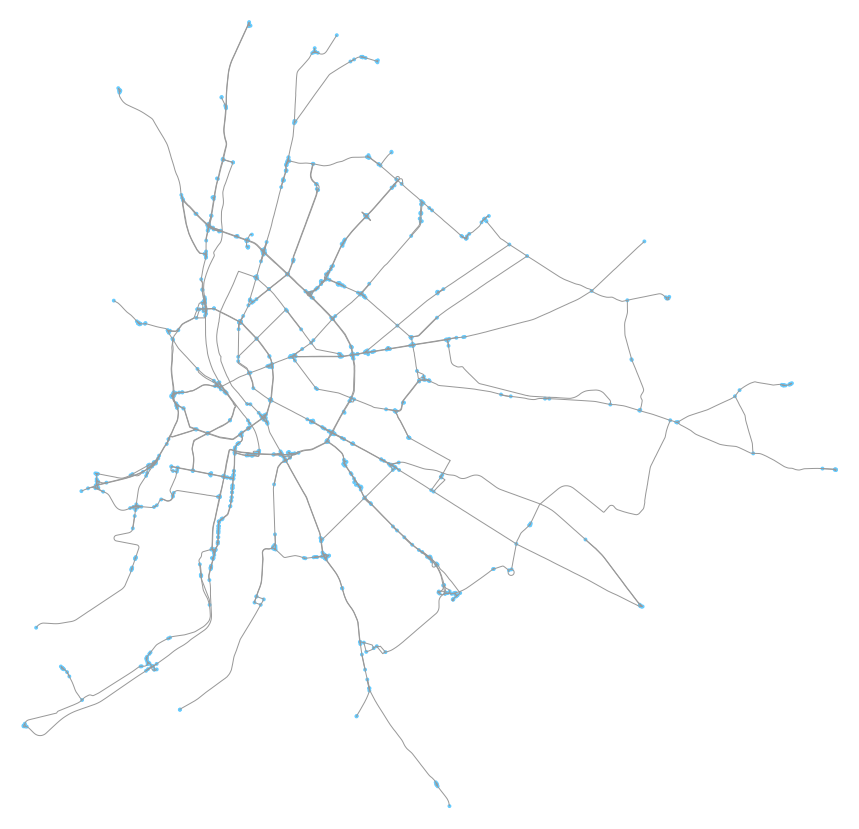

In [3]:
plt.figure(figsize=(15,15))
ox.plot_graph(Gu,fig_height=15)
plt.show()

Let's focus on the downtown, otherwise, the area is still to big for this hands-on session.

In [4]:
Gt = ox.truncate_graph_bbox(Gu,47.544889,47.461857,19.123493,19.004703,retain_all=True)
nodes = ox.graph_to_gdfs(Gt, edges=False)
nodes.head()

AttributeError: module 'osmnx' has no attribute 'truncate_graph_bbox'

This is far too big for an analysis by hand. But how to merge the nodes? Let's stick those together that are near each other.

In [5]:
aggc = AgglomerativeClustering(n_clusters=30,compute_full_tree=True)
res = aggc.fit(nodes[['x','y']])
d = {n:res.labels_[i] for i,n in enumerate(Gt.nodes())}
nodes["cluster"] = res.labels_

NameError: name 'nodes' is not defined

In [ ]:
ox.plot_graph(Gt,fig_height=15,node_color=res.labels_)
plt.show()

In [ ]:
pos = nodes.groupby("cluster").mean()[['x','y']]
Gs = nx.from_edgelist(list(set((d[i],d[j]) for i,j in Gt.edges() if d[i]!=d[j])))
plt.figure(figsize=(12,12))
posdict = pos.T.apply(lambda row: tuple(row)).to_dict()
nx.draw_networkx_nodes(Gs,posdict,node_size=1000,node_color='yellow')
nx.draw_networkx_edges(Gs,posdict)
nx.draw_networkx_labels(Gs,posdict,labels = {k:str(k+1) for k in posdict.keys()}, font_size=16)
plt.axis('off')
plt.show()

In [ ]:
print("Edgelist:")
print("["+",".join([str(e) for e in Gs.edges()])+"]\n")
print("Node positions:")
print(posdict)

In [ ]:
mymap = folium.Map(location=((47.544889+47.461857)/2,(19.123493+19.004703)/2),tiles='cartodbpositron',zoom_start=12)

for e in Gt.edges():
    folium.PolyLine(
        [
            [posdict[d[e[0]]][1],posdict[d[e[0]]][0]],
            [posdict[d[e[1]]][1],posdict[d[e[1]]][0]]
        ],
        linewidth=1,
        color='black'
    ).add_to(mymap)

for k,e in posdict.items():
    folium.Circle(
        (e[1],e[0]),
        150,
        fill_color='yellow',
        color='yellow',
        opacity=1,
        fill_opacity=1
    ).add_to(mymap)
    folium.Marker(
        (e[1],e[0]),
        icon=folium.DivIcon(
            html='<div style="font-size: 10pt; text-align: center; position: absolute;top: -30%; left: 10%;">'+str(k+1)+'</div>',
        )
    ).add_to(mymap)
    
mymap.save('bp.html')
mymap

The size of the nodes corresponds to the betweenness centrality.

In [ ]:
mymap = folium.Map(location=((47.544889+47.461857)/2,(19.123493+19.004703)/2),tiles='cartodbpositron',zoom_start=12)

for e in Gt.edges():
    folium.PolyLine(
        [
            [posdict[d[e[0]]][1],posdict[d[e[0]]][0]],
            [posdict[d[e[1]]][1],posdict[d[e[1]]][0]]
        ],
        linewidth=1,
        color='black'
    ).add_to(mymap)

bc = nx.betweenness_centrality(Gs,normalized=True)
    
for k,e in posdict.items():
    folium.Circle(
        (e[1],e[0]),
        1500*bc[k],
        fill_color='yellow',
        color='yellow',
        opacity=1,
        fill_opacity=1
    ).add_to(mymap)
    folium.Marker(
        (e[1],e[0]),
        icon=folium.DivIcon(
            html='<div style="font-size: 10pt; text-align: center; position: absolute;top: -30%; left: 10%;">'+str(k+1)+'</div>',
        )
    ).add_to(mymap)
    
mymap

Let's do it computationally for the big graph.

In [ ]:
nodes_big = ox.graph_to_gdfs(Gu, edges=False)
aggc = AgglomerativeClustering(n_clusters=200,compute_full_tree=True)
res_big = aggc.fit(nodes_big[['x','y']])
d_big = {n:res_big.labels_[i] for i,n in enumerate(Gu.nodes())}
nodes_big["cluster"] = res_big.labels_

The network without a map, but node locations are real-life positions.

/home/bokanyie/.anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


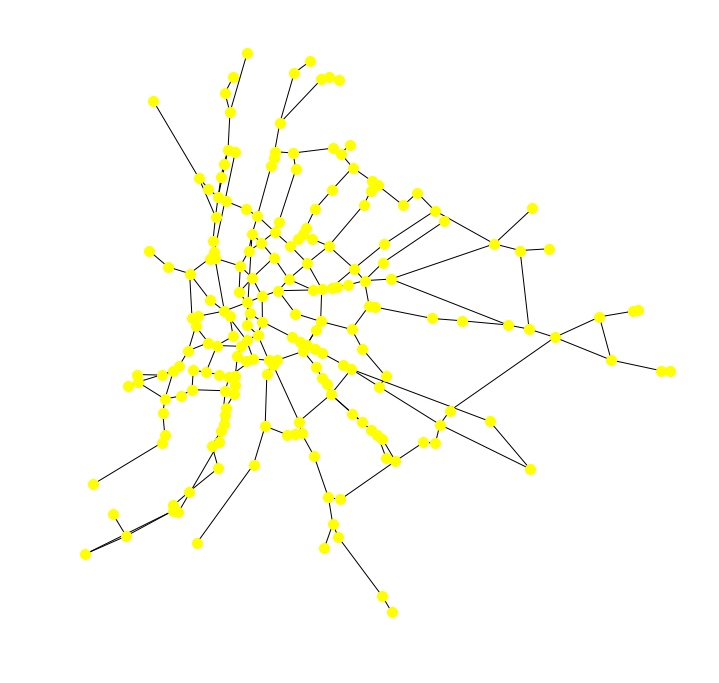

In [11]:
pos_big = nodes_big.groupby("cluster").mean()[['x','y']]
Gs_big = nx.from_edgelist(list(set((d_big[i],d_big[j]) for i,j in Gu.edges())))
plt.figure(figsize=(12,12))
posdict_big = pos_big.T.apply(lambda row: tuple(row)).to_dict()
nx.draw_networkx_nodes(Gs_big,posdict_big,node_size=100,node_color='yellow')
nx.draw_networkx_edges(Gs_big,posdict_big)
plt.axis('off')
plt.show()

The size of the nodes corresponds to the betweenness centrality.

In [12]:
mymap = folium.Map(location=((47.544889+47.461857)/2,(19.123493+19.004703)/2),tiles='cartodbpositron',zoom_start=11)

for e in Gu.edges():
    folium.PolyLine(
        [
            [posdict_big[d_big[e[0]]][1],posdict_big[d_big[e[0]]][0]],
            [posdict_big[d_big[e[1]]][1],posdict_big[d_big[e[1]]][0]]
        ],
        linewidth=0.2,
        color='black'
    ).add_to(mymap)

bc_big = nx.betweenness_centrality(Gs_big,normalized=True)
    
for k,e in posdict_big.items():
    folium.Circle(
        (e[1],e[0]),
        1500*bc_big[k],
        fill_color='yellow',
        color='yellow',
        opacity=1,
        fill_opacity=1
    ).add_to(mymap)
    
mymap